# COVID19 evolution analysis

#### data loading

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tools
import plotly.express as px

In [4]:
df_naz = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../external_data/ProtezioneCivile/COVID-19/dati-province/dpc-covid19-ita-province.csv').drop('stato',1)
df_world_confirmed = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_world_deaths = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_world_recovered = pd.read_csv('../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [5]:
df_prov[df_prov.index==df_prov.index.max()]

,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,delta_totale_casi,%delta_totale_casi,growth_factor
data,,,,,,,,,,,
03/16/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,22,2.0,0.100000,0.666667
03/16/2020,1,Piemonte,6,Alessandria,AL,44.912974,8.615401,273,66.0,0.318841,2.640000
03/16/2020,11,Marche,42,Ancona,AN,43.616760,13.518875,323,56.0,0.209738,1.076923
03/16/2020,2,Valle d'Aosta,7,Aosta,AO,45.737503,7.320149,105,48.0,0.842105,3.200000
03/16/2020,11,Marche,44,Ascoli Piceno,AP,42.853223,13.576911,21,7.0,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
03/16/2020,5,Veneto,27,Venezia,VE,45.434905,12.338452,356,28.0,0.085366,0.608696
03/16/2020,5,Veneto,24,Vicenza,VI,45.547497,11.545971,287,52.0,0.221277,0.732394
03/16/2020,5,Veneto,23,Verona,VR,45.438390,10.993527,425,90.0,0.268657,1.500000


## Italy

### diffusion heatmap for provinces

In [12]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [13]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

### National evolution

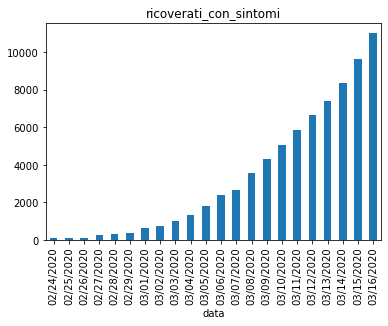

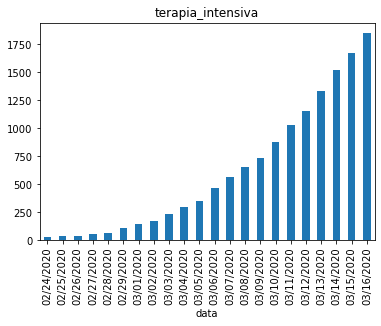

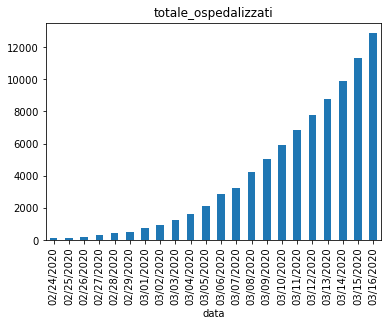

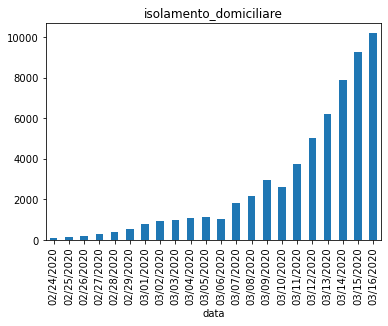

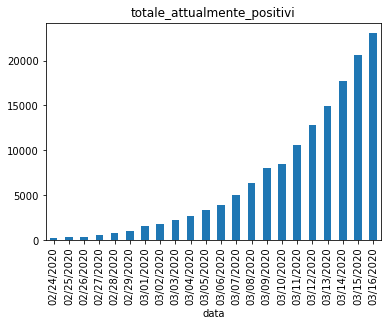

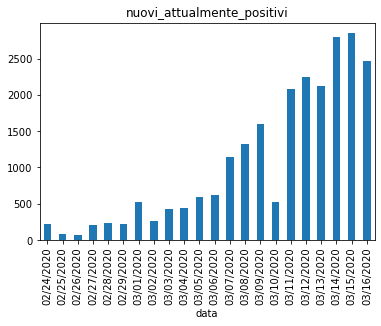

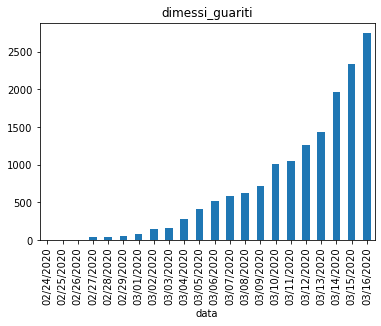

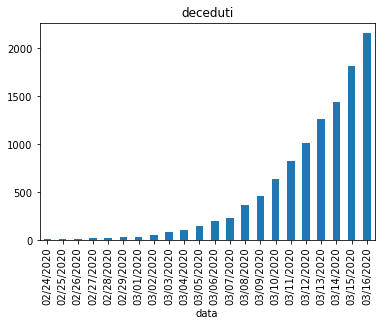

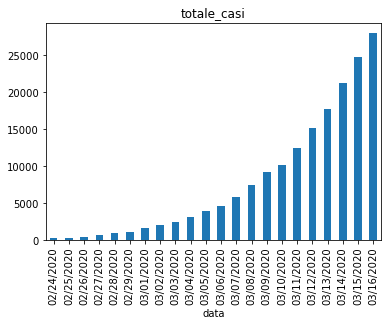

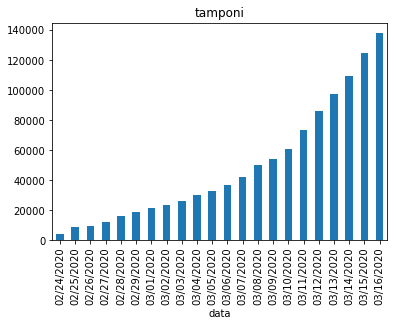

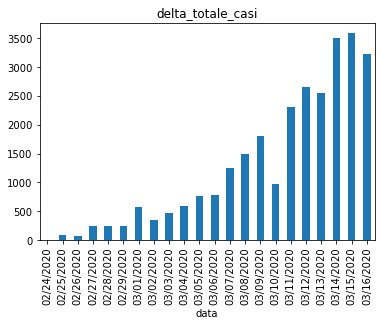

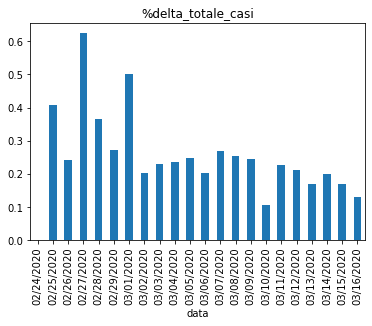

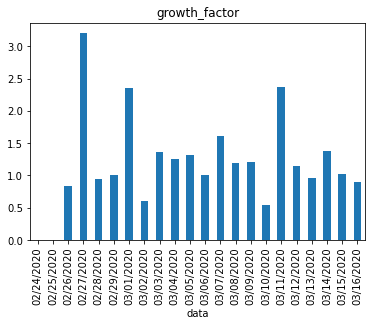

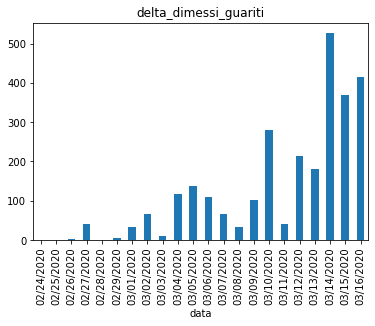

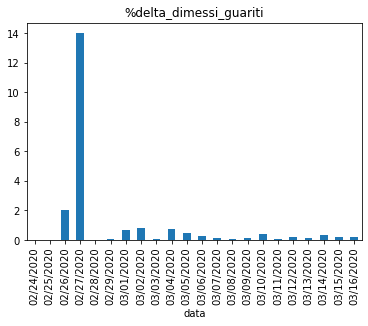

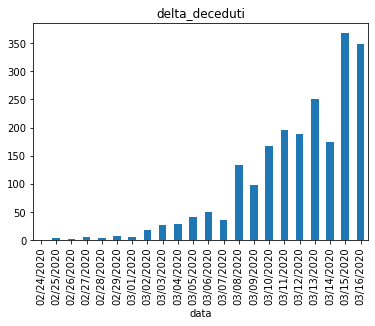

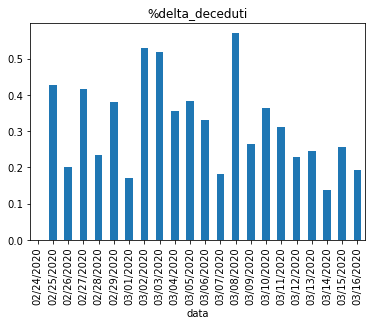

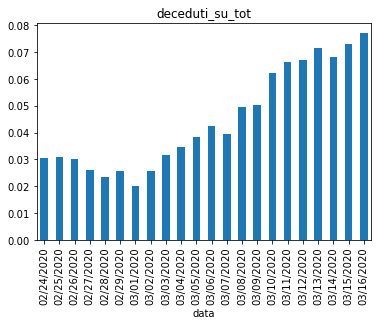

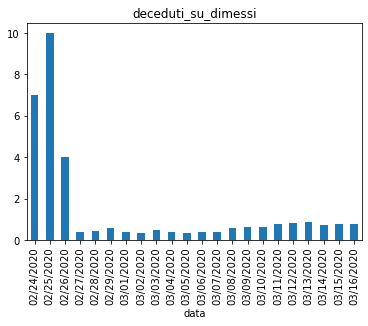

In [14]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

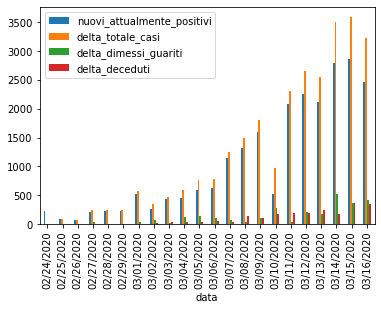

In [15]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

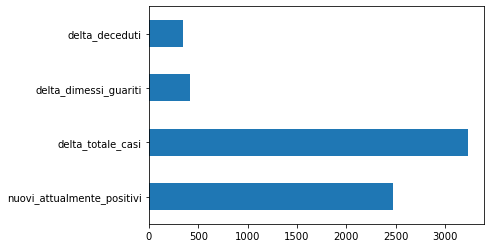

In [16]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].iloc[-1].plot(kind='barh')

Text(0.5, 1.0, "variazione giornaliera nuovi casi per l'Abruzzo")

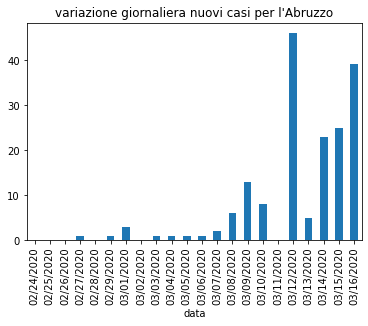

In [17]:
df_reg['Abruzzo']['delta_totale_casi'].plot(kind='bar')
plt.title("variazione giornaliera nuovi casi per l'Abruzzo")

### Logistic model evolution

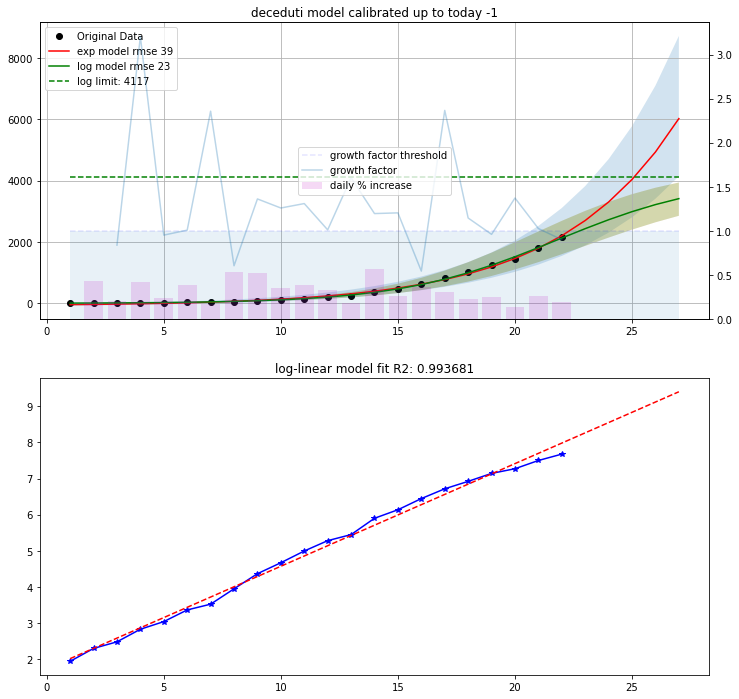

next day prediction for log model:  2436
next day prediction for exp model:  2701
next day prediction for pol model:  2537
data
03/12/2020    1016
03/13/2020    1266
03/14/2020    1441
03/15/2020    1809
03/16/2020    2158
Name: deceduti, dtype: int64


In [69]:
tools.plot_model(df_naz, 'deceduti', backward_fit=-1, forward_look=5, plotlimit=True, show_pol=False)

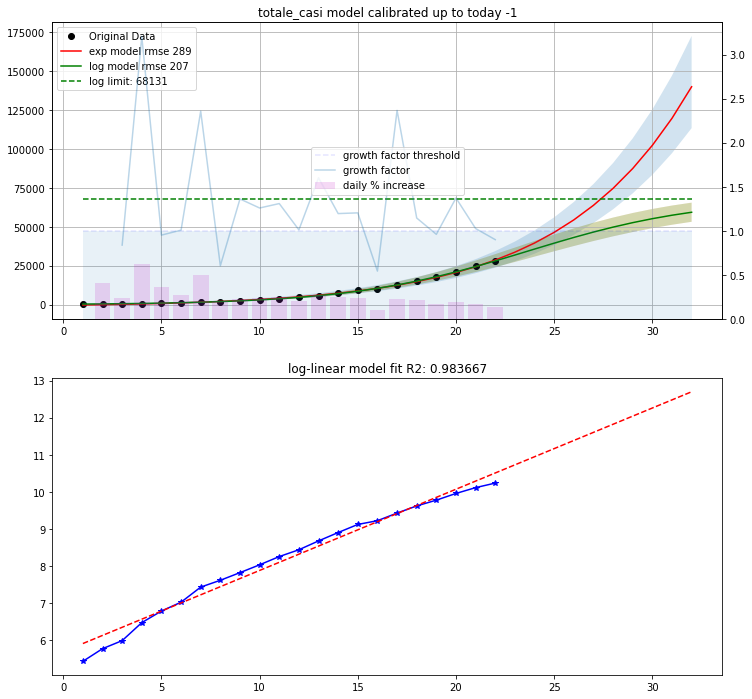

next day prediction for log model:  31869
next day prediction for exp model:  33697
next day prediction for pol model:  32532
data
03/12/2020    15113
03/13/2020    17660
03/14/2020    21157
03/15/2020    24747
03/16/2020    27980
Name: totale_casi, dtype: int64


In [70]:
tools.plot_model(df_naz, 'totale_casi', backward_fit=-1, forward_look=10, plotlimit=True, show_pol=False)

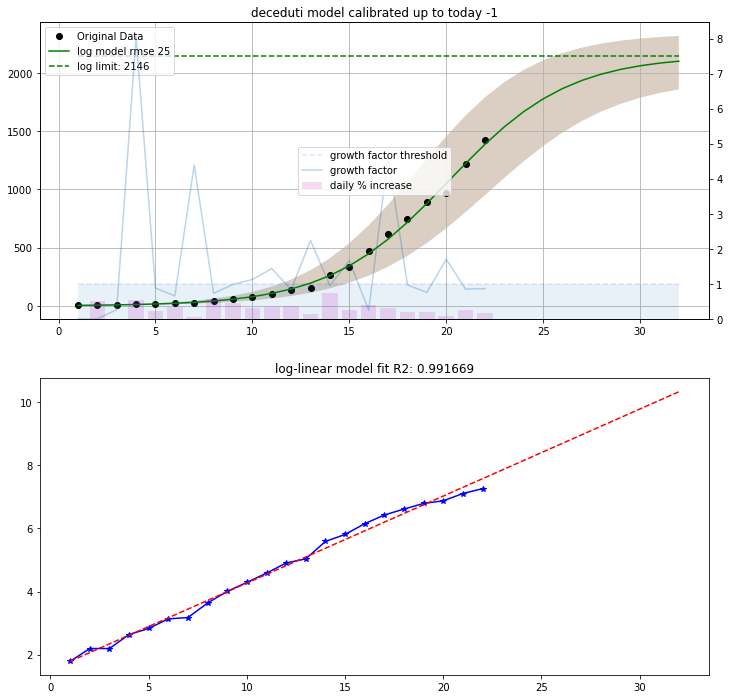

next day prediction for log model:  1537
data
03/12/2020     744
03/13/2020     890
03/14/2020     966
03/15/2020    1218
03/16/2020    1420
Name: deceduti, dtype: int64


In [114]:
tools.plot_model(df_reg['Lombardia'], 'deceduti', backward_fit=-1, forward_look=10, plotlimit=True, show_pol=False, show_exp=False)

In [172]:
china_deaths = df_world_deaths[df_world_deaths['Country/Region']=='China'].groupby('Country/Region').sum().drop('Lat',1).drop('Long',1).T#
china_deaths.index = pd.to_datetime(china_deaths.index)

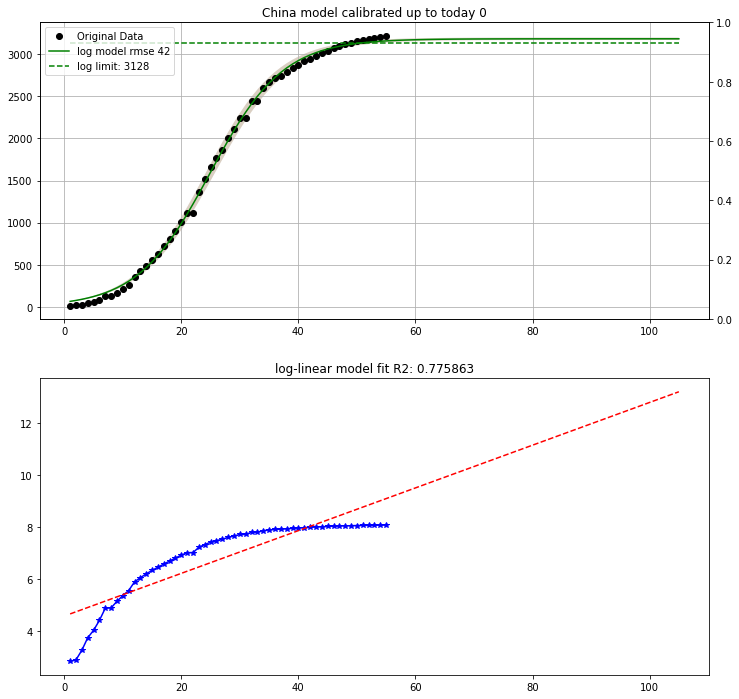

next day prediction for log model:  3162
2020-03-12    3172
2020-03-13    3180
2020-03-14    3193
2020-03-15    3203
2020-03-16    3217
Name: China, dtype: int64


In [173]:
tools.plot_model(china_deaths, 'China', backward_fit=-0, forward_look=50, plotlimit=True, show_pol=False, show_exp=False)

In [180]:
df_naz

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,delta_totale_casi,%delta_totale_casi,growth_factor,delta_dimessi_guariti,%delta_dimessi_guariti,delta_deceduti,%delta_deceduti,deceduti_su_tot,deceduti_su_dimessi
data,,,,,,,,,,,,,,,,,,,
02/24/2020,101,26,127,94,221,221,1,7,229,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030568,7.000000
02/25/2020,114,35,150,162,311,90,1,10,322,8623,93.0,0.406114,NaN,0.0,0.000000,3.0,0.428571,0.031056,10.000000
02/26/2020,128,36,164,221,385,74,3,12,400,9587,78.0,0.242236,0.838710,2.0,2.000000,2.0,0.200000,0.030000,4.000000
02/27/2020,248,56,304,284,588,203,45,17,650,12014,250.0,0.625000,3.205128,42.0,14.000000,5.0,0.416667,0.026154,0.377778
02/28/2020,345,64,409,412,821,233,46,21,888,15695,238.0,0.366154,0.952000,1.0,0.022222,4.0,0.235294,0.023649,0.456522
02/29/2020,401,105,506,543,1049,228,50,29,1128,18661,240.0,0.270270,1.008403,4.0,0.086957,8.0,0.380952,0.025709,0.580000
03/01/2020,639,140,779,798,1577,528,83,34,1694,21127,566.0,0.501773,2.358333,33.0,0.660000,5.0,0.172414,0.020071,0.409639
03/02/2020,742,166,908,927,1835,258,149,52,2036,23345,342.0,0.201889,0.604240,66.0,0.795181,18.0,0.529412,0.025540,0.348993
03/03/2020,1034,229,1263,1000,2263,428,160,79,2502,25856,466.0,0.228880,1.362573,11.0,0.073826,27.0,0.519231,0.031575,0.493750


In [177]:
china_deaths['shifted'] = china_deaths.shift(36).values
df_compare = pd.concat((china_deaths['shifted'],df_naz['deceduti']),1).dropna()
df_compare.columns = ['Italy', 'China']
df_compare.reset_index(drop=True, inplace=True)

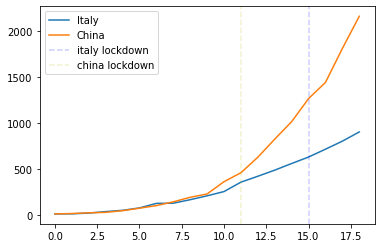

In [189]:
df_compare.plot()
plt.axvline(x=15, label='italy lockdown', alpha=0.2, color='b', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='y', linestyle='--')
plt.legend()

In [108]:
from fbprophet import Prophet